In [28]:
import pandas
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

We will fit an ARX model of this form to a step response.

$$y(k) = a_1 y(k - 1) + a_2 y(k - 2) + b_1 u(k - 1) + b_2 u(k - 2)$$

In [29]:
data = pandas.read_csv('../../assets/data.csv', index_col='k')
data['uk'] = 1
data.loc[0] = [0, 1]  # input changes at t=0
data.loc[-1] = [0, 0]  # everything was steady at t < 0
data = data.sort_index()
data

,yk,uk
k,,
-1,0.000,0
0,0.000,1
1,0.058,1
2,0.217,1
3,0.360,1
4,0.488,1
5,0.600,1
6,0.692,1
7,0.772,1


In [30]:
y = data.yk
u = data.uk

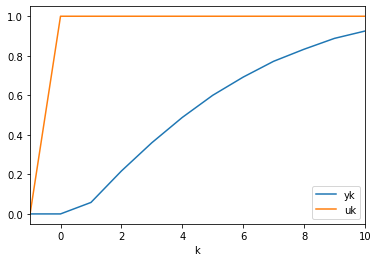

In [31]:
data.plot()

We effectively have the following equations (I repeat the equation here for convenience):

$$y(k) = a_1 y(k - 1) + a_2 y(k - 2) + b_1 u(k - 1) + b_2 u(k - 2)$$

In [32]:
for k in range(1, 11):
    print(f'{y[k]:.2} = a1×{y[k - 1]:.2} + a2×{y[k - 2]:.2} + b1×{u[k - 1]} + b2×{u[k - 2]}')

0.058 = a1×0.0 + a2×0.0 + b1×1 + b2×0
0.22 = a1×0.058 + a2×0.0 + b1×1 + b2×1
0.36 = a1×0.22 + a2×0.058 + b1×1 + b2×1
0.49 = a1×0.36 + a2×0.22 + b1×1 + b2×1
0.6 = a1×0.49 + a2×0.36 + b1×1 + b2×1
0.69 = a1×0.6 + a2×0.49 + b1×1 + b2×1
0.77 = a1×0.69 + a2×0.6 + b1×1 + b2×1
0.83 = a1×0.77 + a2×0.69 + b1×1 + b2×1
0.89 = a1×0.83 + a2×0.77 + b1×1 + b2×1
0.93 = a1×0.89 + a2×0.83 + b1×1 + b2×1


In [33]:
pandas.DataFrame([(k, 
                  y[k], 
                  y[k-1], 
                  y[k-2], 
                  u[k-1], 
                  u[k-2]) for k in range(1, 11)], columns=['k', 'y[k]', 'y[k-1]', 'y[k-2]', 'u[k-1]', 'u[k-2]'])

,k,y[k],y[k-1],y[k-2],u[k-1],u[k-2]
0,1,0.058,0.000,0.000,1,0
1,2,0.217,0.058,0.000,1,1
2,3,0.360,0.217,0.058,1,1
3,4,0.488,0.360,0.217,1,1
4,5,0.600,0.488,0.360,1,1
5,6,0.692,0.600,0.488,1,1
6,7,0.772,0.692,0.600,1,1
7,8,0.833,0.772,0.692,1,1
8,9,0.888,0.833,0.772,1,1
9,10,0.925,0.888,0.833,1,1


We notice that these equations are linear in the coefficients. We can define $\beta= [a_1, a_2, b_1, b_2]^T$. Now, to write the above equations in matrix form $Y = X \beta $, we define

In [34]:
Y = numpy.atleast_2d(y.loc[1:]).T
Y

array([[0.058],
       [0.217],
       [0.36 ],
       [0.488],
       [0.6  ],
       [0.692],
       [0.772],
       [0.833],
       [0.888],
       [0.925]])

To build the coefficient matrix we observe that there are two blocks of constant diagonals (the part with the $y$s and the part with the $u$s). Matrices with constant diagonals are called Toeplitz matrices and can be constructed with the `scipy.linalg.toeplitz` function.

In [35]:
import scipy
import scipy.linalg

In [36]:
X1 = scipy.linalg.toeplitz(y.loc[0:9], [0, 0])
X1

array([[0.   , 0.   ],
       [0.058, 0.   ],
       [0.217, 0.058],
       [0.36 , 0.217],
       [0.488, 0.36 ],
       [0.6  , 0.488],
       [0.692, 0.6  ],
       [0.772, 0.692],
       [0.833, 0.772],
       [0.888, 0.833]])

In [37]:
X2 = scipy.linalg.toeplitz(u.loc[0:9], [0, 0])
X2

array([[1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1]])

In [24]:
X = numpy.hstack([X1, X2])

In [25]:
X

array([[0.   , 0.   , 1.   , 0.   ],
       [0.058, 0.   , 1.   , 1.   ],
       [0.217, 0.058, 1.   , 1.   ],
       [0.36 , 0.217, 1.   , 1.   ],
       [0.488, 0.36 , 1.   , 1.   ],
       [0.6  , 0.488, 1.   , 1.   ],
       [0.692, 0.6  , 1.   , 1.   ],
       [0.772, 0.692, 1.   , 1.   ],
       [0.833, 0.772, 1.   , 1.   ],
       [0.888, 0.833, 1.   , 1.   ]])

Another option is to use the loop from before to construct the matrices. This is a little more legible but slower:

In [26]:
Y = []
X = []
for k in range(1, 11):
    Y.append([y[k]])
    X.append([y[k - 1], y[k - 2], u[k - 1], u[k - 2]])
Y = numpy.array(Y)
X = numpy.array(X)

We solve for $\beta$ as we did for linear regression:

In [27]:
beta, _, _, _ = numpy.linalg.lstsq(X, Y, rcond=None)
beta

array([[ 0.98464753],
       [-0.12211256],
       [ 0.058     ],
       [ 0.10124916]])